In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import calendar
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [2]:
train = train[train['weather'] != 4]

In [3]:
all_data = pd.concat([train, test], ignore_index=True)

In [4]:
all_data['tempDate'] = pd.to_datetime(all_data['datetime'])

all_data['hour'] = all_data['tempDate'].dt.hour
all_data['dayofweek'] = all_data['tempDate'].dt.dayofweek
# all_data['month'] = all_data['tempDate'].dt.month
all_data['year'] = all_data['tempDate'].dt.year
all_data['weekend'] = (all_data['dayofweek'] ==5) | (all_data['dayofweek'] == 6)
all_data = all_data.drop('tempDate', axis=1)

In [5]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1)
pca.fit(all_data[['temp', 'atemp']])
all_data['pca']=pca.fit_transform(all_data[['temp','atemp']])

In [6]:
# # atemp
# def predict_atemp(data):
#     validData = data[(data["atemp"] > 15) | (data["temp"] <= 20)]
#     invalidData = data[(data["atemp"] <= 15) & (data["temp"] > 20)]

#     lin_atemp = LinearRegression()
#     lin_atemp.fit(validData[["temp"]], validData[["atemp"]])

#     predict_atemp = lin_atemp.predict(invalidData[["temp"]])
    
#     invalidData.loc[:, "atemp"] = predict_atemp

#     data = pd.concat([validData, invalidData], ignore_index=True)

#     return data

In [7]:
# all_data = predict_atemp(all_data)

In [8]:
# windspeed
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]

    windColumns = ["weather", "humidity", "pca"]

    rf_wind = RandomForestRegressor(random_state=42)
    rf_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
    wind0 = rf_wind.predict(X=dataWind0[windColumns])
    
    dataWind0.loc[:, "windspeed"] = wind0
    data = pd.concat([dataWindNot0, dataWind0], ignore_index = True)
    
    return data

In [9]:
all_data = predict_windspeed(all_data)
# all_data.loc[all_data['windspeed']==0, 'windspeed']=all_data['windspeed'].mean()
all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,year,weekend,pca
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0.0,1.0,1.0,5,5,2011,True,-15.162435
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12.0,24.0,36.0,10,5,2011,True,-6.260307
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26.0,30.0,56.0,11,5,2011,True,-9.047071
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29.0,55.0,84.0,12,5,2011,True,-4.035214
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47.0,47.0,94.0,13,5,2011,True,-1.810121


In [10]:
# humidity
def predict_humidity(data):
    dataHum0 = data[data["humidity"]==0]
    dataHumNot0 = data[data["humidity"]!=0]

    humidityColumns = ["weather", "windspeed", "pca"]

    rf_humidity = RandomForestRegressor(random_state = 42)
    rf_humidity.fit(dataHumNot0[humidityColumns], dataHumNot0["humidity"])

    predictHumidity0 = rf_humidity.predict(X= dataHum0[humidityColumns])
    dataHum0.loc[:, "humidity"] = predictHumidity0

    data = pd.concat([dataHumNot0, dataHum0], ignore_index=True)

    return data


In [11]:
#all_data = predict_humidity(all_data)

In [12]:
# from sklearn.decomposition import PCA
# pca=PCA(n_components=1)
# pca.fit(all_data[['temp', 'atemp']])


In [13]:
# all_data['pca']=pca.fit_transform(all_data[['temp','atemp']])

C:\Users\cch\AppData\Local\Temp\ipykernel_11408\2669888132.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_data['pca'], fit=norm)


<Axes: xlabel='pca', ylabel='Density'>

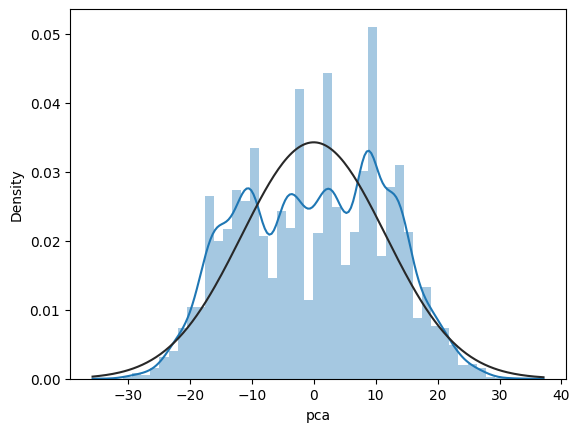

In [14]:
import seaborn as sns
from scipy.stats import norm

sns.distplot(all_data['pca'], fit=norm)


In [15]:
all_data = all_data.drop(columns=['temp', 'atemp'], axis=1)

In [16]:
#oheFeatures = ["holiday", "weather", 'season', 'workingday']
#all_data = pd.get_dummies(all_data, columns=oheFeatures)

In [17]:
new_train = all_data[pd.notnull(all_data['count'])].sort_values(by=["datetime"])
new_test = all_data[~pd.notnull(all_data['count'])].sort_values(by=["datetime"])

In [18]:
target = new_train["count"]
target1 = new_train["casual"]
target2 = new_train["registered"]

In [19]:
dropFeatures = ["casual", "count", "datetime", "registered"]
new_train  = new_train.drop(dropFeatures, axis=1)
new_test  = new_test.drop(dropFeatures, axis=1)

In [20]:
target = np.log(target+1)
target1 = np.log(target1+1)
target2 = np.log(target2+1)

In [21]:
new_train.head()

,season,holiday,workingday,weather,humidity,windspeed,hour,dayofweek,year,weekend,pca
15198,1,0,0,1,81,7.500315,0,5,2011,True,-14.046290
15199,1,0,0,1,80,6.445608,1,5,2011,True,-15.160679
15200,1,0,0,1,80,6.445608,2,5,2011,True,-15.160679
15201,1,0,0,1,75,7.594985,3,5,2011,True,-14.046290
15202,1,0,0,1,75,7.594985,4,5,2011,True,-14.046290


In [22]:
import numpy as np
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [23]:
from sklearn.metrics import make_scorer
RMSLE = make_scorer(rmsle_score)

In [24]:
from sklearn.model_selection import train_test_split 

X_train, X_validation, y_train, y_validation = train_test_split(new_train, target, test_size=0.2, shuffle=True)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

'''param_Rf =  {'min_samples_split' : [3,4,6,10], 'n_estimators' : [100], 'random_state': [42] }
RF = make_pipeline(GridSearchCV(RandomForestRegressor(), param_Rf, cv=10, scoring = RMSLE, n_jobs = -1))
RF.fit(new_train, target)'''

"param_Rf =  {'min_samples_split' : [3,4,6,10], 'n_estimators' : [100], 'random_state': [42] }\nRF = make_pipeline(GridSearchCV(RandomForestRegressor(), param_Rf, cv=10, scoring = RMSLE, n_jobs = -1))\nRF.fit(new_train, target)"

In [26]:
param_Rf =  {'min_samples_split' : [3,4,6,10], 'n_estimators' : [100], 'random_state': [42] }
RF = make_pipeline(GridSearchCV(RandomForestRegressor(), param_Rf, cv=10, scoring = RMSLE, n_jobs = -1))
RF.fit(new_train, target1)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=10, estimator=RandomForestRegressor(),
                              n_jobs=-1,
                              param_grid={'min_samples_split': [3, 4, 6, 10],
                                          'n_estimators': [100],
                                          'random_state': [42]},
                              scoring=make_scorer(rmsle_score)))])

In [27]:
RF_yhat = RF.predict(X_validation)
s_RF = rmsle_score(RF_yhat, y_validation)
s_RF

0.5318983761023373

In [28]:
pred_rf1 = RF.predict(new_test)

In [29]:
param_Rf =  {'min_samples_split' : [3,4,6,10], 'n_estimators' : [100], 'random_state': [42] }
RF = make_pipeline(GridSearchCV(RandomForestRegressor(), param_Rf, cv=10, scoring = RMSLE, n_jobs = -1))
RF.fit(new_train, target2)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=10, estimator=RandomForestRegressor(),
                              n_jobs=-1,
                              param_grid={'min_samples_split': [3, 4, 6, 10],
                                          'n_estimators': [100],
                                          'random_state': [42]},
                              scoring=make_scorer(rmsle_score)))])

In [30]:
RF_yhat = RF.predict(X_validation)
s_RF = rmsle_score(RF_yhat, y_validation)
s_RF

0.06884803655803107

In [31]:
pred_rf2 = RF.predict(new_test)

In [32]:
sub = pd.DataFrame()
sub['datetime'] = test['datetime']
sub['count'] = np.exp(pred_rf1) + np.exp(pred_rf2) - 2


sub.to_csv('submission1.csv', index=False)